# Задание на аналитику результатов кластеризации: 
1. Проанализировать результат кластеризации
2. Описать каждый кластер и какой сегмент клиентов он характеризует.
3. Сделать выводы о данной кластеризации. Какие плюсы и минусы в используемых подходах и результатах?
4. Какие бизнес задачи вы бы решали, с помощью представленных кластеров?
5. Какие улучшения вы бы предложили?


In [133]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/clusters/clusters.csv


In [134]:
#импорт данных с результатами кластеризации
df = pd.read_csv('/kaggle/input/clusters/clusters.csv')
df.head(3)

,month,credit_amount,credit_term,age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target,cluster
0,1,7000,12,39,male,Secondary special education,Cell phones,0,2,21000,Another,0,0,0,3
1,1,19000,6,20,male,Secondary special education,Household appliances,1,2,17000,Another,3,1,0,3
2,1,29000,12,23,female,Secondary special education,Household appliances,0,2,31000,Another,2,0,0,3


In [135]:
#проверка типов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   month                1723 non-null   int64 
 1   credit_amount        1723 non-null   int64 
 2   credit_term          1723 non-null   int64 
 3   age                  1723 non-null   int64 
 4   sex                  1723 non-null   object
 5   education            1723 non-null   object
 6   product_type         1723 non-null   object
 7   having_children_flg  1723 non-null   int64 
 8   region               1723 non-null   int64 
 9   income               1723 non-null   int64 
 10  family_status        1723 non-null   object
 11  phone_operator       1723 non-null   int64 
 12  is_client            1723 non-null   int64 
 13  bad_client_target    1723 non-null   int64 
 14  cluster              1723 non-null   int64 
dtypes: int64(11), object(4)
memory usage: 202.0+ KB


#### Выполним визуализацию данных с категориями

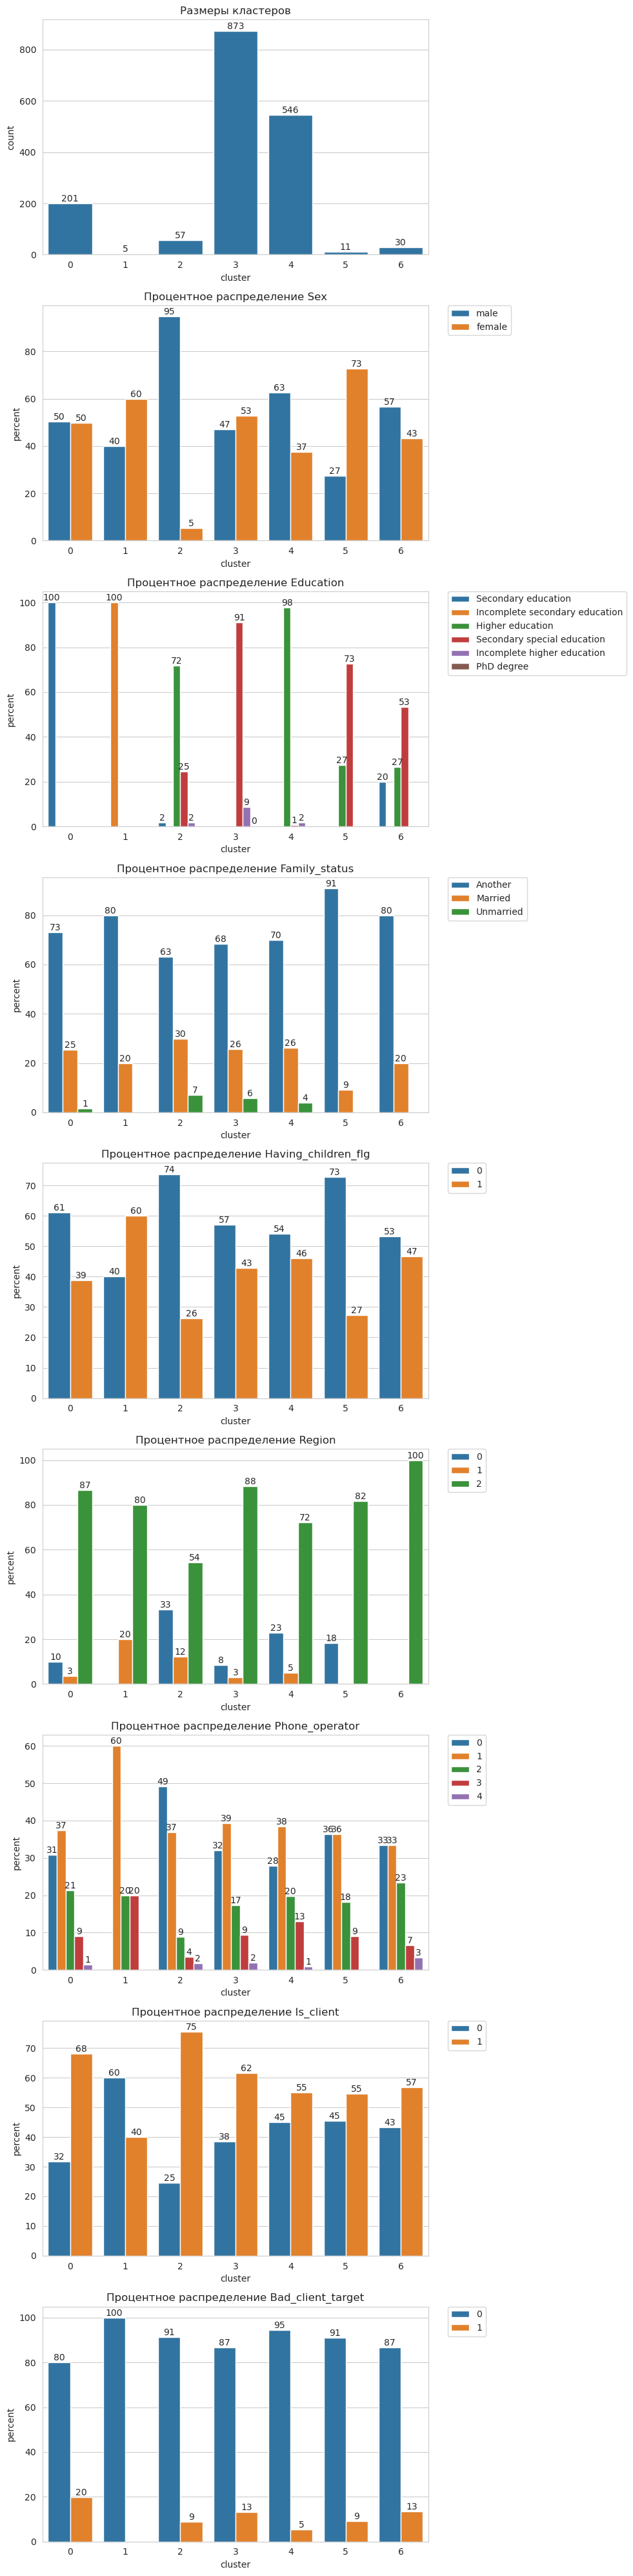

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

#выделим поля, данные в которых можно представить в виде категорий
cols = ['sex', 'education','family_status', 'having_children_flg', 'region', 'phone_operator', 'is_client', 'bad_client_target']
fig, axes = plt.subplots(len(cols)+1,1,figsize=(10,len(cols)*5))

#проверка размеров кластеров
sns.countplot(data=df, x='cluster', ax=axes[0], color='#1f77b4').set(title='Размеры кластеров')

#построение графиков с процентным соотношением по категориям для каждого из выбранных полей для анализа
for axn, catname in enumerate(cols):
    df1 = df.groupby('cluster')[catname].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    sns.barplot(data=df1, x='cluster', y='percent', hue=catname, ax=axes[axn+1]).set(title=f'Процентное распределение {str.capitalize(catname)}')
    axes[axn+1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)   
    #axes[axn+1].set_yscale('log')

for a in axes:
    for container in a.containers:
        a.bar_label(container, fmt='%.0f')
    
fig.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


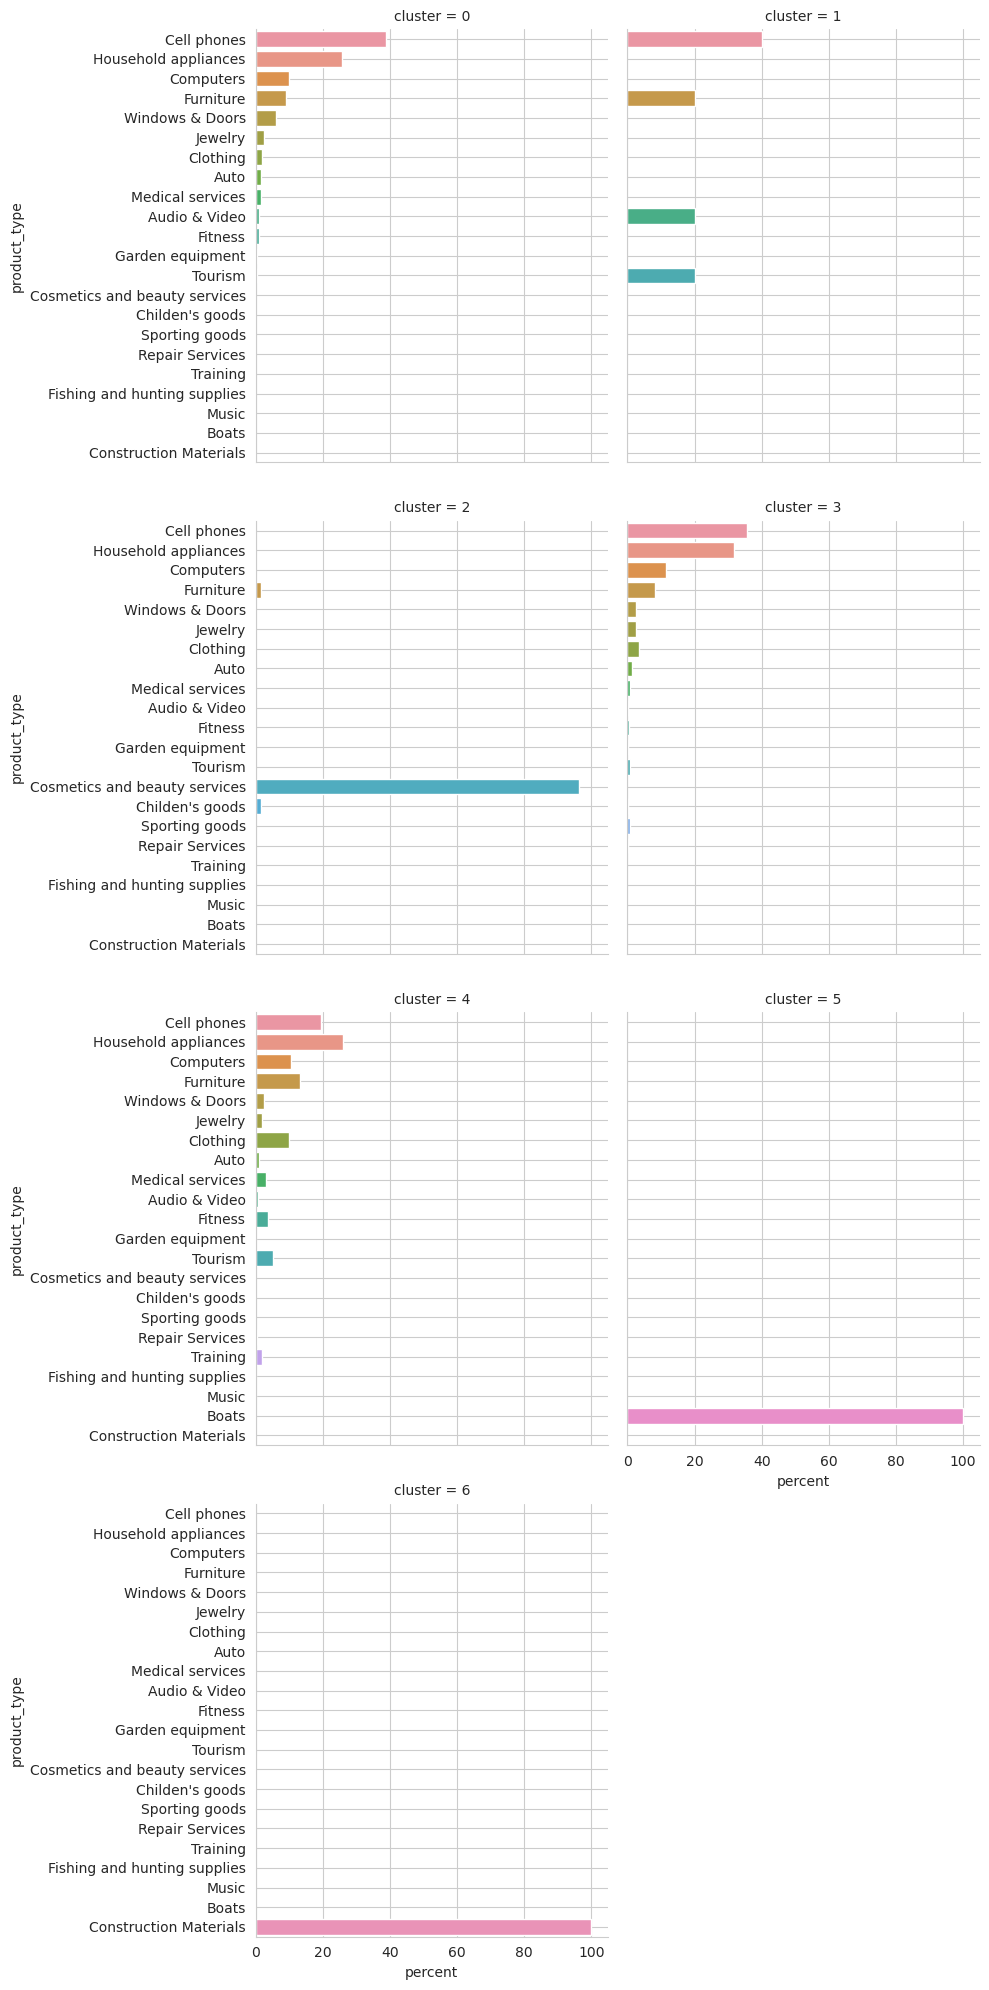

In [137]:
#поле Product type имеет слишком много категорий для отображения на одном bar chart. 
#для данного поля построим отдельные графики для каждого кластера
sns.set_style('whitegrid')
df1 = df.groupby('cluster')['product_type'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
g = sns.catplot(data=df1, kind='bar', col='cluster', y='product_type', x='percent', col_wrap=2)
for ax in g.axes.flatten():
    ax.grid('x') 

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


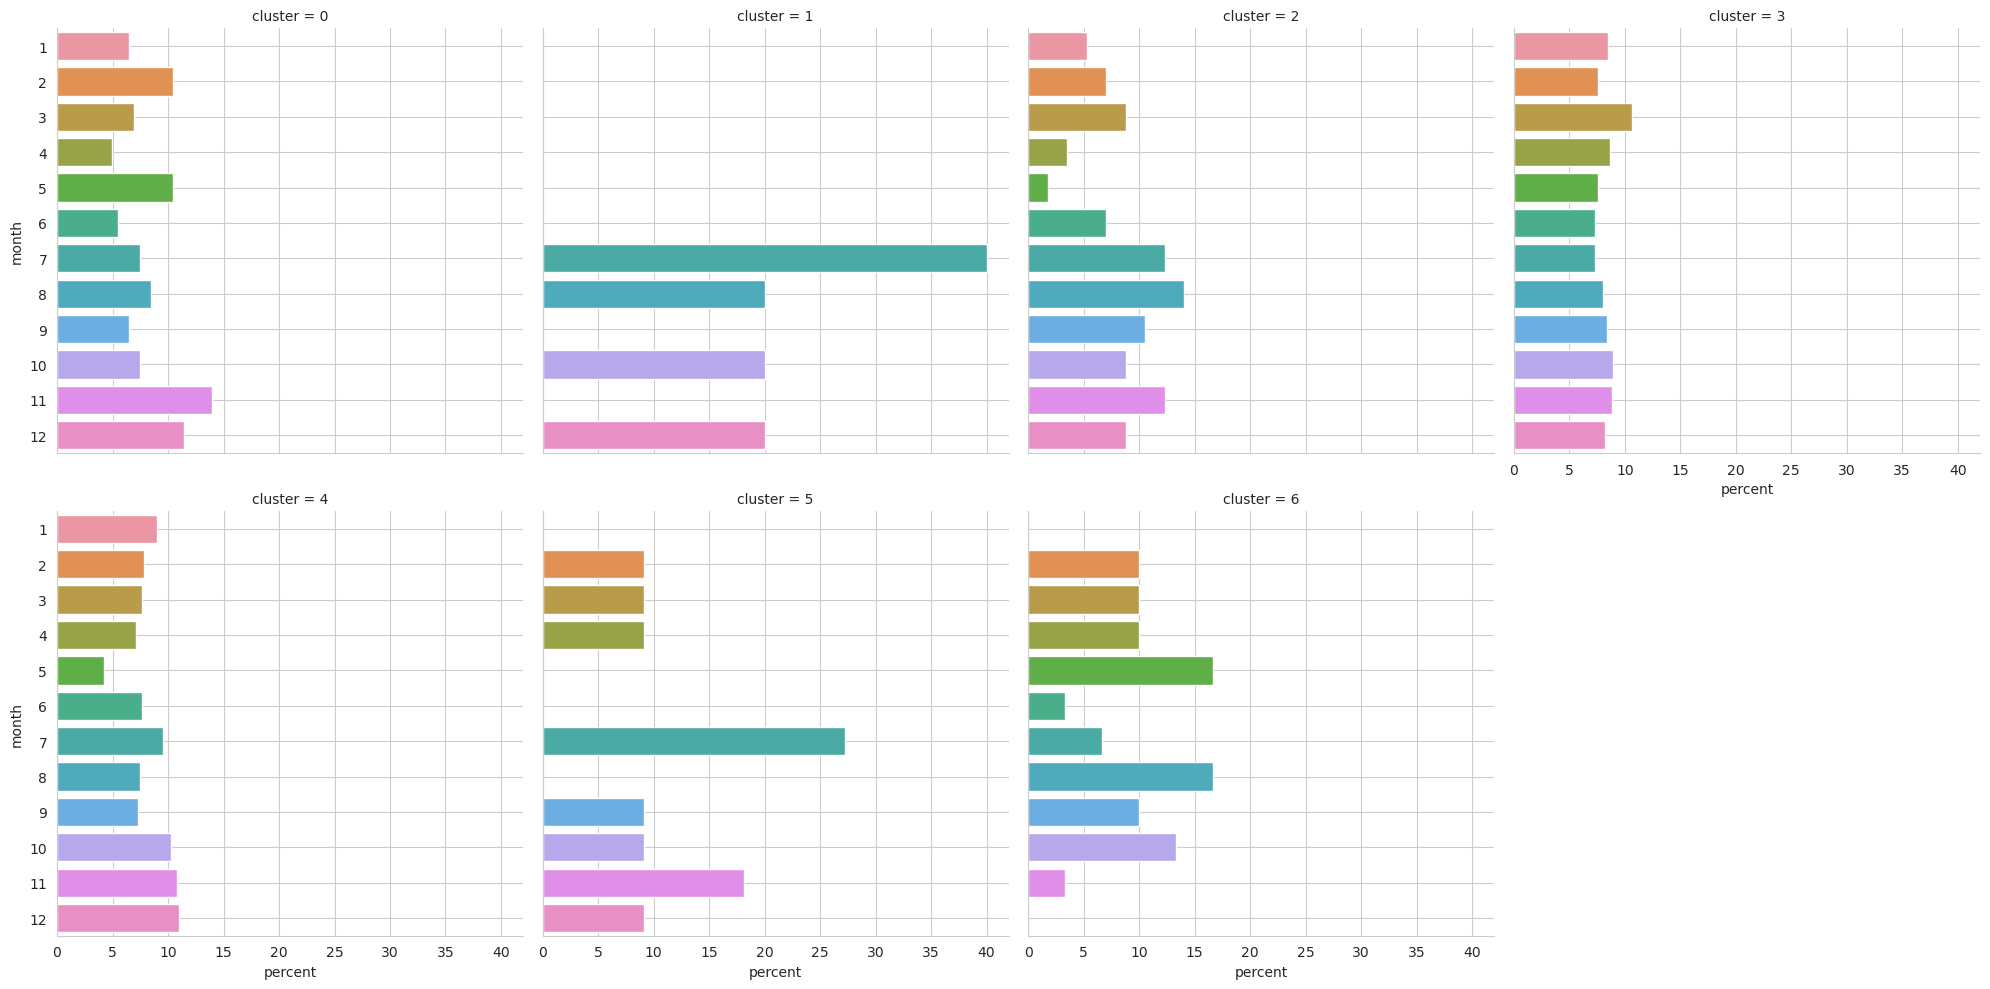

In [138]:
#аналогично предыдущей визуализации построим графики для Month для проверки наличия сезонного спроса
sns.set_style('whitegrid')
df1 = df.groupby('cluster')['month'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
g = sns.catplot(data=df1, kind='bar', col='cluster', y='month', x='percent', orient='h', col_wrap=4)
for ax in g.axes.flatten():
    ax.grid('x') 

#### Далее построим графики для числовых полей
используем box plot - компактный и информативный график для визуализации нескольких распределений

(0.0, 120000.0)

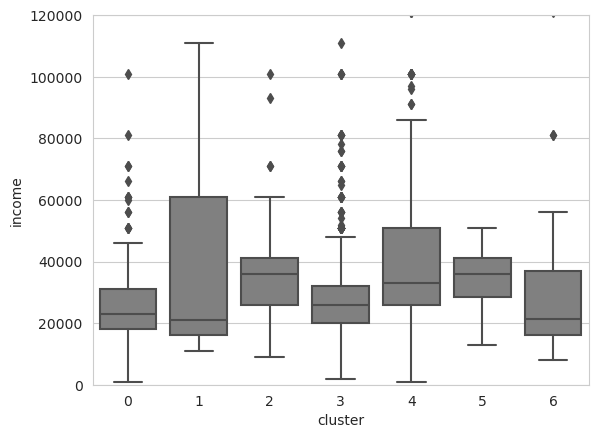

In [139]:
sns.boxplot(data=df, x='cluster', y='income', color='grey')
plt.ylim(0, 120000)

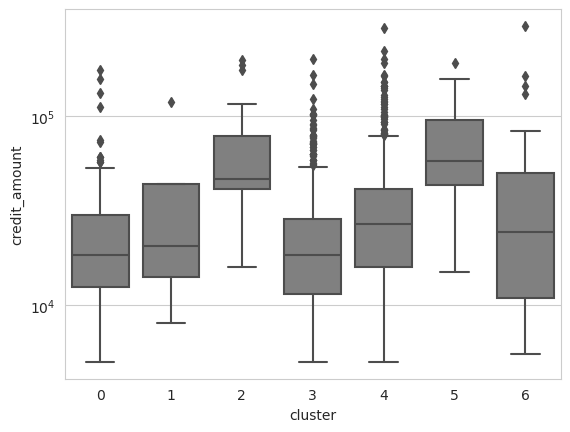

In [140]:
sns.boxplot(data=df, x='cluster', y='credit_amount', color='grey')
plt.yscale('log')

<Axes: xlabel='cluster', ylabel='credit_term'>

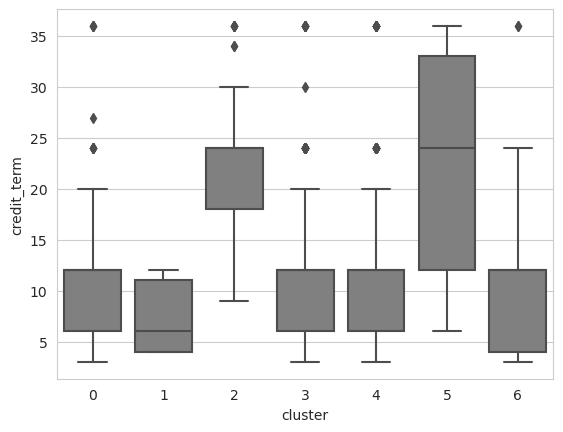

In [141]:
sns.boxplot(data=df, x='cluster', y='credit_term', color='grey')

<Axes: xlabel='cluster', ylabel='age'>

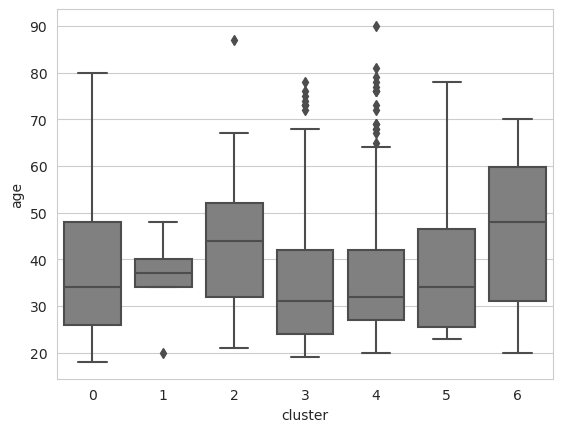

In [142]:
sns.boxplot(data=df, x='cluster', y='age', color='grey')

In [143]:
#для поиска наиболее значимых переменных для выделения кластера построим Decision tree и обучим на данных с полученными кластерами
from sklearn.preprocessing import StandardScaler
import pandas_summary as ps

#используем оригинальный код для очистки даных и приведения к форме, пригодной для построения модели
mapper = dict((val, i) for i, val in enumerate(df.sex.unique()))
dfm = df
dfm['sex'] = df['sex'].map(mapper)

dfs = ps.DataFrameSummary(df)
categoricals = dfs.categoricals.tolist()
dfm = pd.get_dummies(dfm, columns=categoricals, drop_first=False)

dfm.drop('month', axis=1, inplace=True)

clusters = dfm.cluster
dfm.drop('cluster', axis=1, inplace=True)

#df_scaled = dfm

scaler = StandardScaler()
df_scaled = scaler.fit_transform(dfm)
df_scaled = pd.DataFrame(df_scaled, columns=dfm.columns)


/tmp/ipykernel_32/1881137633.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfs = ps.DataFrameSummary(df)


In [144]:
#ограничим глубину и минимальное количество наблюдений на листе дерева для упрощения модели и поиска наиболее значимых переменных
from sklearn.tree import DecisionTreeClassifier, plot_tree
min_samples_leaf=3
depth=4
dtr = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, max_depth=depth)
dtr.fit(df_scaled, clusters)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=3)

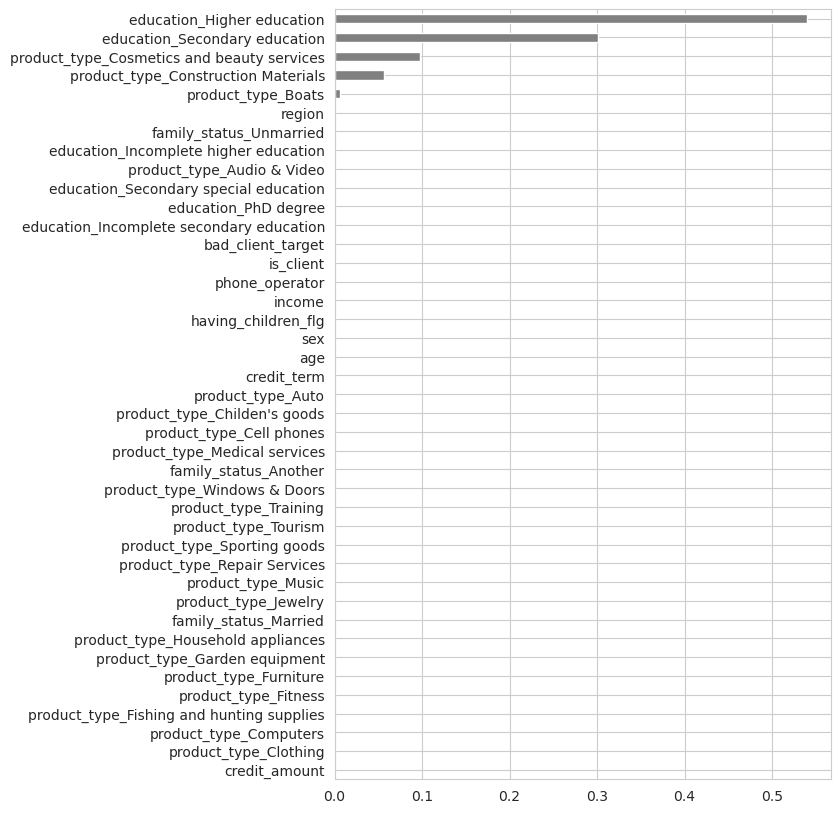

In [145]:
#выведем полученные коэффициенты значимости переменных на графике
plt.figure().set_figheight(10)
importances_rf = pd.Series(dtr.feature_importances_, index = df_scaled.columns)

sorted_importances_rf = importances_rf.sort_values()

sorted_importances_rf.plot(kind='barh', color='grey')
plt.show()

|--- education_Higher education <= 0.34
|   |--- education_Secondary education <= 1.16
|   |   |--- product_type_Construction Materials <= 3.69
|   |   |   |--- product_type_Cosmetics and beauty services <= 2.66
|   |   |   |   |--- weights: [0.00, 5.00, 1.00, 873.00, 13.00, 8.00, 0.00] class: 3
|   |   |   |--- product_type_Cosmetics and beauty services >  2.66
|   |   |   |   |--- weights: [0.00, 0.00, 14.00, 0.00, 0.00, 0.00, 0.00] class: 2
|   |   |--- product_type_Construction Materials >  3.69
|   |   |   |--- weights: [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 16.00] class: 6
|   |--- education_Secondary education >  1.16
|   |   |--- product_type_Construction Materials <= 3.69
|   |   |   |--- region <= -1.68
|   |   |   |   |--- weights: [20.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00] class: 0
|   |   |   |--- region >  -1.68
|   |   |   |   |--- weights: [181.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00] class: 0
|   |   |--- product_type_Construction Materials >  3.69
|   |   |   |--- weigh

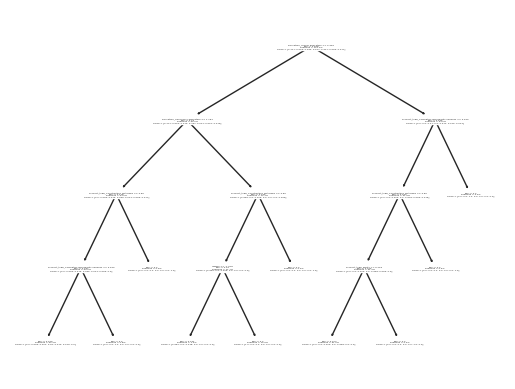

In [146]:
#для дополнительного анализа отобразим дерево в виде схемы, а также в текстовом виде
from sklearn.tree import export_text
plot_tree(dtr, feature_names=df_scaled.columns, proportion=True)
plt.savefig('tree.png', dpi=600)

r = export_text(dtr, feature_names=list(dtr.feature_names_in_), show_weights=True)
print(r)


#### Проверим гипотезу о наличии зависимости доли клиентов, покупающих сотовые от их мобильного оператора.
Визуализируем данные о пропорциях клиентов с продуктом Сотовые в зависимости от оператора

/tmp/ipykernel_32/325726582.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_cell'][df['is_cell'] != 1] = 0


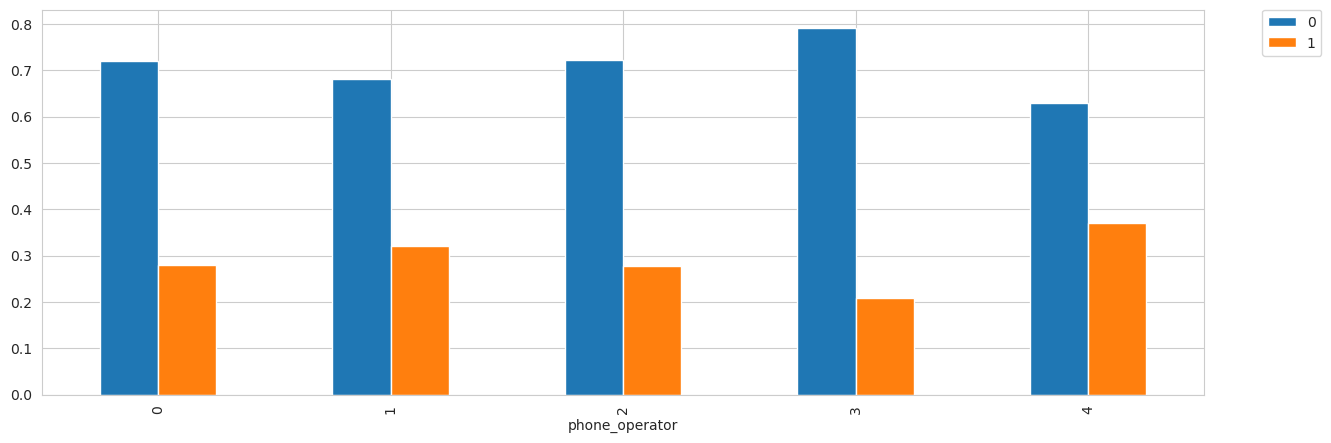

In [147]:
#добавим бинарное поле с 1 если продукт сотовые и 0 в остальных случаях
df['is_cell'] = df['product_type'].replace('Cell phones', 1)
df['is_cell'][df['is_cell'] != 1] = 0

#построим визуализацию процентного соотношения покупки сотовых в зависимости от оператора
cells_props = df.groupby('phone_operator')['is_cell'].value_counts(normalize=True)
cells_props_wide = cells_props.unstack()
cells_props_wide.plot(kind='bar', figsize=(15,5)).legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [148]:
#выводим абсолютные значения для анализа
cells = df.groupby('is_cell')['phone_operator'].value_counts()
cells_wide = cells.unstack()
cells_wide

phone_operator,0,1,2,3,4
is_cell,,,,,
0,386,453,229,140,17
1,150,213,88,37,10


In [149]:
#выполняем тест chi-2 тест независимости с нулевой гипотезой об отсутствии зависимости продаж сотовых от оператора
from scipy.stats import chi2_contingency
res = chi2_contingency(cells_wide)
p_value = res[1]
p_value

0.04259790550536925

p-value 0.042 ниже значимого уровня 0.05, что говорит об опровержении нулевой гипотезы и наличии зависимости продаж сотовых от оператора